# <span style="color:green"> Numerical Simulation Laboratory: Numerical Exercises 5 </span>
## <span style="color:darkorange"> Comment on the C++ code - Structure </span> 
 <span style="color:red">**Preliminary note**: this C++ program requires the version C++17 since it makes use of the function $\mathrm{sph\_legendre}$, contained in the header *cmath* only in the case of C++17 or higher.</span><br><br>
The C++ code relies on the base class **Orbital** (orbital.h, orbital.cpp) and on its derived class **MetropolisOrbitals** (metropolisorbitals.h, metropolisorbitals.cpp). In particular, Orbital contains: 
1. Data:
    - The quantum numbers Z (atomic number), n (principal QN), l (angular momentum (QN) and ml (magnetic QN)
2. Methods:
    - The main methods are $\mathrm{Laguerre(x)}$, which computes the Laguerre polynomials, $\mathrm{sph\_legendre(l, m, \theta)}$ (defined in header *cmath* of C++17) and $\mathrm{pv\_nn(Vector)}$, which returns the probability density of the wave function $\psi$ without normalization. 
    
Instead MetropolisOrbitals contains:
1. Data:
    - One Random Generator (random.h)
    - An array of Vector (vector.h), which represents generic $d$-dimensional points/vectors in a vector space
    - A pointer to a probability density function
2. Methods: 
    - the methods $\mathrm{GenerateUniform(double\&\thinspace R)}$ and $\mathrm{GenerateGaussian(double\&\thinspace R)}$ implement the Metropolis algorithm using a probability density function $p(x, y, z) = |\psi(x, y, z)|^2$. The formes tries to sample a new point in a cubic region with uniform probability (radius $R$), while the latter uses a multivariate Gaussian probability distribution, centered in the actual position, with $\sigma=\mathrm{R}$. Both methods rely on the function $\mathrm{pv_nn(Vector)}$ of the class Orbital, since the Metropolis algorithm allows to discard the normalization of the probability density.
    - the methods $\mathrm{CalibrateUniform(double\&\thinspace R)}$ and $\mathrm{CalibrateGaussian(double\& \thinspace R)}$ perform the calibration of the range of motion $R$. When the calibration starts, it prints on screen the actual value of $R$ and the acceptance ratio achieved, then it asks whether to continue with a new value of $R$ or quit. One fundamental feature is that once the user stops the calibration cycle, the final value of $R$ is overwritten to the value read from the input file **input.dat**.

The file **auxiliary.cpp** contains all the input and output functions.
The output (xyz coordinates and the progressive values of $\langle r \rangle$) is contained in the folder **OutputData**.

## <span style="color:darkorange"> Comment on the C++ code - Usage </span>
All the interactions with the user rely on the input file **input.dat**, which has the following structure:<br>

| *Value*           | *Description*                         |
|:----------:|:-----------------------------------------|
| 1000000         | Sample size                             |
| 250             | Number of blocks (blocking method)      |
| 990000, 1000000 | Range of the sample to be saved on file |
| 10000           | Calibration steps                       |
|3 | Number of orbitals to be computed|

|Z   | n   | l   | m   | Uniform radius | Gaussian radius | Calibration  |X start|Y start|Z start|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1   | 1   | 0   | 0   | 1.22           | 0.74            | true         | 1     | 0.5   | 1     |
|1   | 2   | 1   | 0   | 2.95           | 1.84            | true         | 1     | 1     | 2     |
2    | 6    | 5    | -3   | 7.6       | 5.08       | true         | 3     | 5     | 19    

This means that the user can decide the number of points generated and the fraction to be saved on file (third line), the number of blocks (blocking method), the calibration steps and a generic number of orbitals $\mathrm{N_{orbitals}}$. After that, there must be a number of lines equal to $\mathrm{N_{orbitals}}$ with all the data required: the quantum numbers, the values $R$ for the uniform and gaussian sampling, true/false to launch or skip the calibration cycle for each single orbital, and the coordinates of the starting point.<br>
<span style="color:firebrick">**Important**. The function $\mathrm{OutputFinalSetup(...)}$ overwrites **input.dat** at the end of the program. If at least one calibration is performed, it substitutes the final values of $R$ used in the calibration process. The only requirement for the structure of the input file is to **preserve the number of lines** (in agreement with the number of orbitals represented) **and the separation between the numerical values and the text**. The **spacing is immaterial**: indeed, when the file is overwritten by the program, the original table-like structure is automatically restored.

## <span style="color:darkorange"> Comment on the Python code </span>
We define here the functions that gather the bulky code, with the aim of making the plots easier to visualize and compare.<br>
**ReadParam** reads the file **input.dat** and returns the main parameters of the system.<br>
**ReadXYZ** reads the files **(name).xyz**, which contain the coordinates of the points representing the orbitals' probability density functions. <br>
**ReadRadius** reads the files **(name).out** containing the radii's *progressive averages*.<br>
**ProduceLists** creates four useful lists: *Title* (titles of the graphs), *Filename* (automatically generated filenames), *PsiString* (the string $|\Psi_{n, l, m}(r, \theta, \phi)|^2, Z=[...]$) and *ExpR* (expected $\langle r \rangle$).

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Returns the expected <r> in a0 units (Bohr radius)
def ExpectedMeanR(Z, n, l): 
    return float(3*n**2-l*(l+1))/float(2*Z)

# System parameters (from input.dat)
def ReadParam(filename):
    with open("Esercizio05.1/"+filename) as file:
        Z, n, l, m, r_unif, r_gauss, x0, y0, z0 = [[] for i in range(9)]
        QN = [Z, n, l, m]
        R = [r_unif, r_gauss]
        Start = [x0, y0, z0]
        Nsample, Nblocks = [int(file.readline().split()[0]) for i in range(2)]
        line = file.readline().split()
        first, last = line[0], line[1]
        CalibSteps = int(file.readline().split()[0])
        for i in range(2): file.readline()
        Norbitals = int(file.readline().split()[0])
        for i in range(2): file.readline()
        for i in range(Norbitals):
            line = file.readline().split()
            for q in range(4):
                QN[q].append(int(line[2*q]))
            for q in range(2):
                R[q].append(float(line[8+2*q]))
            for q in range(3):
                Start[q].append(float(line[14+2*q]))
    return Nsample, Nblocks, CalibSteps, Norbitals, QN, R, Start

# Read the progressive averages and errors of r
def ReadRadius(filename):
    mean, sigma = [], []
    with open("Esercizio05.1/OutputData/"+filename+".out") as file:
        Nsample, Nblocks = [int(file.readline().split()[1]) for i in range(0, 2)]
        for line in file:
            mean.append(float(line.split()[0]))
            sigma.append(float(line.split()[1]))
    return [mean, sigma]

def ReadXYZ(filename):
    X, Y, Z = [], [], []
    with open("Esercizio05.1/OutputData/"+filename+".xyz") as file:
        for line in file:
            X.append(float(line.split()[0]))
            Y.append(float(line.split()[1]))
            Z.append(float(line.split()[2]))
    return [X, Y, Z]

# Generate the filenames (in agreement with the choices made in the C++ program), the titles, the expected <r>
def ProduceLists(Norbitals, QN):
    Filename, PsiString, ExpR, Title = [], [], [], []
    for i in range(Norbitals):
        string = str(QN[0][i])+"."+str(QN[1][i])+"."+str(QN[2][i])+"."+str(QN[3][i])
        Filename.append(string+"_unif")
        Filename.append(string+"_gauss")
        string = str(QN[1][i])+", "+str(QN[2][i])+", "+str(QN[3][i])
        PsiString.append(fr"$|\Psi_{{{string}}}(x, y, z)|^2$, Z={QN[0][i]}")
        ExpR.append(ExpectedMeanR(QN[0][i], QN[1][i], QN[2][i]))
        Title.append(PsiString[i]+r", Uniform sampling")
        Title.append(PsiString[i]+r", Gaussian sampling")
    return Filename, PsiString, ExpR, Title

# Progressive averages and errors (Uniform sampling, Gaussian sampling plots of <r>)
def PlotRadius(Norbitals, Nblocks, ProgRadius, ExpR, Title):
    fig, ax = plt.subplots(nrows=Norbitals, ncols=2, figsize=(14, 5*Norbitals))
    fig.suptitle(r"Atomic orbitals - $\langle r\rangle$ (blocking method)", y = 0.95, size=18)
    fig.subplots_adjust(hspace=0.29)
    ax = ax.flatten()
    for i in range(Norbitals):
        ax[2*i].errorbar(np.arange(1, Nblocks+1), ProgRadius[2*i][0], yerr=ProgRadius[2*i][1], color='black', 
                         ecolor='tab:blue', label="Measures") # Measures
        ax[2*i].plot([1, Nblocks+1], [ExpR[i], ExpR[i]], color="tab:red", label="Expected", 
                     linewidth=3) # Expected mean
        ax[2*i].set_title(Title[2*i], fontsize=14)
        ax[2*i].set_xlabel("Blocks", fontsize=12)
        ax[2*i].set_ylabel(r"$\langle r \rangle$ [$a_0$]", fontsize=14)
        ax[2*i].legend(prop={"size":13})

        ax[2*i+1].errorbar(np.arange(1, Nblocks+1), ProgRadius[2*i+1][0], yerr=ProgRadius[2*i+1][1], color='black',
                           ecolor='tab:green', label="Measures")# Measures
        ax[2*i+1].plot([1, Nblocks+1], [ExpR[i], ExpR[i]], color="tab:red", label="Expected", 
                       linewidth=3) # Expected mean
        ax[2*i+1].set_title(Title[2*i+1], fontsize=14)
        ax[2*i+1].set_xlabel("Blocks", fontsize=12)
        ax[2*i+1].set_ylabel(r"$\langle r \rangle$ [$a_0$]", fontsize=14)
        ax[2*i+1].legend(prop={"size":13})

# Coordinates of the points representing the orbitals' probability density functions
def PlotXYZ(Norbitals, XYZ, Title):
    fig = plt.figure(figsize=(14, 6*Norbitals))
    ax = [fig.add_subplot(Norbitals, 2, i+1, projection='3d') for i in range(0, 2*Norbitals)]
    fig.suptitle(r"Atomic orbitals - Probability density", y = 0.90, size=18)

    # Uniform sampling, Gaussian sampling scatterplots of Psi
    for i in range(0, Norbitals):
        ax[2*i].scatter(XYZ[2*i][0], XYZ[2*i][1], XYZ[2*i][2], c=XYZ[2*i][2], marker='.')
        ax[2*i].set_title(Title[2*i], fontsize=14)
        ax[2*i].set_xlabel(r'X $[a_0]$', fontsize=14)
        ax[2*i].set_ylabel(r'Y $[a_0]$', fontsize=14)
        ax[2*i].set_zlabel(r'Z $[a_0]$', fontsize=14)
        ax[2*i].view_init(2, 30)# Uniform sampling. Different angle from the correspondent Gaussian sampling plot
        ax[2*i+1].scatter(XYZ[2*i+1][0], XYZ[2*i+1][1], XYZ[2*i+1][2], c=XYZ[2*i+1][2], marker='.')
        ax[2*i+1].set_title(Title[2*i+1], fontsize=14)
        ax[2*i+1].set_xlabel(r'X $[a_0]$', fontsize=14)
        ax[2*i+1].set_ylabel(r'Y $[a_0]$', fontsize=14)
        ax[2*i+1].set_zlabel(r'Z $[a_0]$', fontsize=14)
        ax[2*i+1].view_init(86, 60) # Different representation of the same orbital (with Gaussian sampling)

## <span style="color:orangered"> Mean radius - blocking method </span>
In this section we represent the progressive average and error of the measure of $r$ for each of the orbitals in Bohr radius units ($a_0$). In particular, we chose to represent $|\Psi_{1,0,0}(x,y,z)|^2$ ($1s$) and $|\Psi_{2,1,0}(x,y,z)|^2$ ($2p$), but we also added the orbital $|\Psi_{6,5,-3}(x,y,z)|^2, Z=2$ since both the C++ program and the python code allow a straightforward generalization (any number of orbitals of any kind). We chose the orbital $Z=2, n=6, l=5, m=-3$ because the algorithm proves to be particularly effective in the computation of its mean radius and its shape. Indeed, when $n$ is high and $l << n$, the algorithm becomes more inaccurate, as it cannot reach all the "separate" regions of the orbital. However, for these three orbitals, the measured values of $\langle r \rangle$ are in excellent agreement with the expected values, given by the formula
\begin{equation}
\langle r \rangle = \frac{3n^2-l(l+1)}{2Z}
\end{equation}

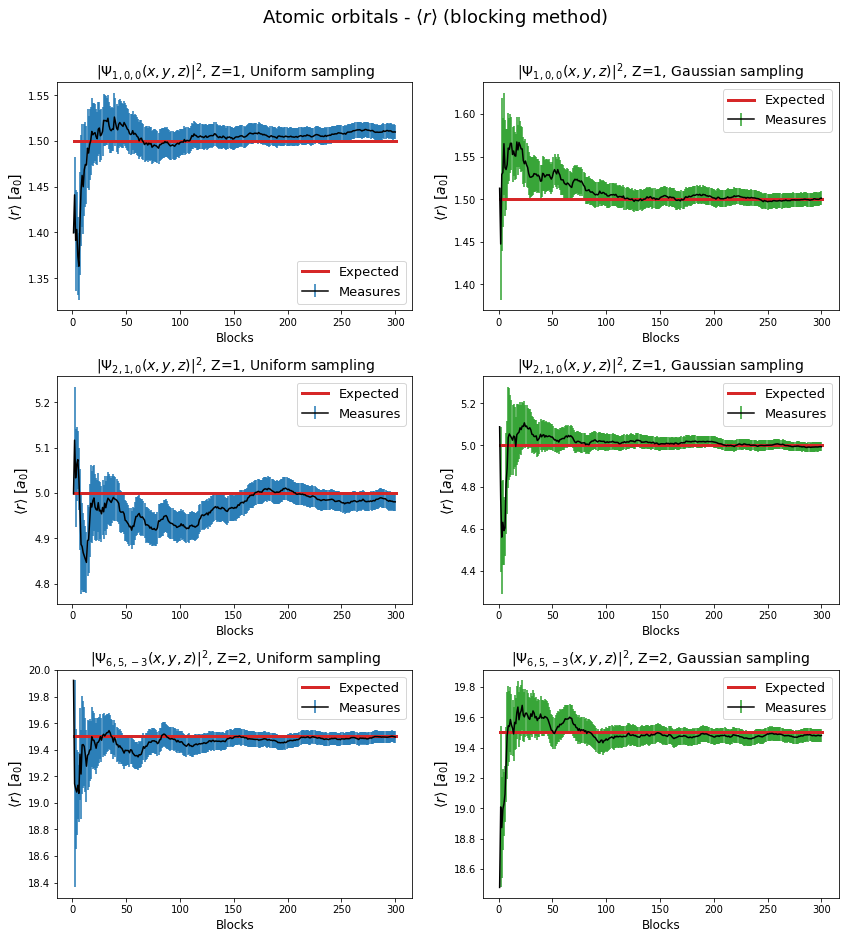

In [2]:
# Number of points and blocks, number of calibration steps, 
# Quantum numbers of the orbitals, radii (unif/gaussian sampling), starting point (vector xyz)
Nsample, Nblocks, CalibSteps, Norbitals, QN, RangeOfMotion, Start = ReadParam("input.dat") 
Filename, PsiString, ExpR, Title = ProduceLists(Norbitals, QN)
# Read progressive average and error of <r>, for each orbital
ProgRadius = []
for i in range(len(Filename)):
    ProgRadius.append(ReadRadius(Filename[i])) # append [average list, error list] for each orbital and sampling
# Plot
PlotRadius(Norbitals, Nblocks, ProgRadius, ExpR, Title)
plt.show()

## <span style="color:orangered"> Shape of the orbitals </span>
Before showing the plots, we read again the parameters of the system from **input.dat**. This allows to run another simulation and plot the new data without altering the previous section (and without the need to restart the jupyter notebook).<br>
We chose to represent the Uniform and Gaussian samplings from two different points of view, since the resulting shapes look very similar. This allows to see with greater details all the regions of the orbitals. In particular, the last plot shows that $|\Psi_{6,5,-3}(x,y,z)|^2, Z=2$ presents a region of low probability density in a neighbourhood of the $z$ axis: this is an effect of the high angular momentum, which tends to move the electrons away from the nucleus.

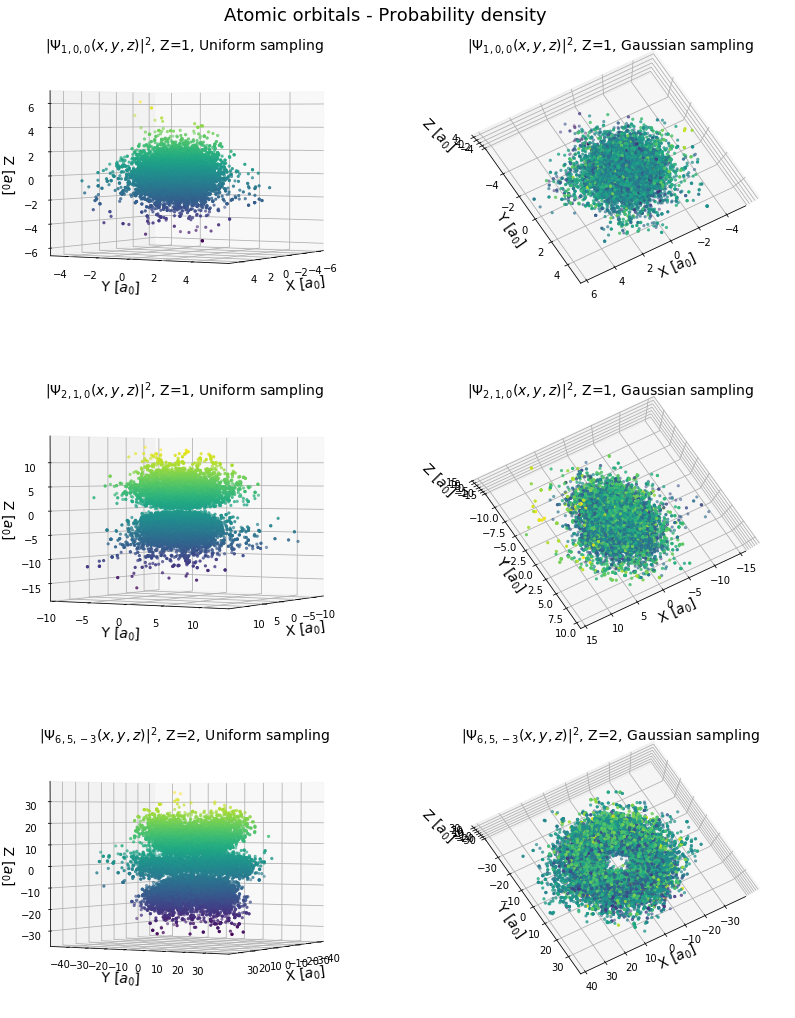

In [3]:
# Number of points and blocks, number of calibration steps, 
# Quantum numbers of the orbitals, radii (unif/gaussian sampling), starting point (vector xyz)
Nsample, Nblocks, CalibSteps, Norbitals, QN, RangeOfMotion, Start = ReadParam("input.dat") 
Filename, PsiString, ExpR, Title = ProduceLists(Norbitals, QN)
# Read the coordinates of the points, for each orbital
XYZ = []
for i in range(len(Filename)):
    XYZ.append(ReadXYZ(Filename[i]))
# Plot
PlotXYZ(Norbitals, XYZ, Title)
plt.show()